In [12]:
import utils
import matplotlib.pyplot as plt

alerts_antof, _ = utils.load_data('data.json')

alerts_antof = utils.separate_coords(alerts_antof)

accident = utils.extract_event(alerts_antof, 'ACCIDENT')
jam = utils.extract_event(alerts_antof, 'JAM')
hazard = utils.extract_event(alerts_antof, 'HAZARD')

hourly_accident = utils.hourly_group(accident)
hourly_jam = utils.hourly_group(jam)
hourly_hazard = utils.hourly_group(hazard)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

linear_model = LinearRegression()

# Join the three DataFrames on the 'hour' index
dat = hourly_accident.join(hourly_jam, lsuffix='_accident', rsuffix='_jam').join(hourly_hazard, rsuffix='_hazard')

dat = dat[['Semana_accident', 'Semana']]

# Fill missing values with 0
dat = dat.fillna(0)

# Create the feature matrix X
X = dat[['Semana']].values

# Create the target vector y
y = dat['Semana_accident'].values

y = hourly_accident.Semana.fillna(0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

y_pred

array([8.77380795, 7.76758855, 3.40730449, 9.78002735, 6.09055622])

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

mean_squared_error(y_test, y_pred)
r2_score(y_test, y_pred)

print(f'Coeficiente de determinación: {r2_score(y_test, y_pred)}')
print(f'Error cuadrático medio: {mean_squared_error(y_test, y_pred)}')


Coeficiente de determinación: 0.2905932839178089
Error cuadrático medio: 7.548087459114514


In [15]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(linear_model, X, y, cv=5)
print(f"R^2 scores: {scores}")

R^2 scores: [ 0.4834283   0.74689515 -5.68415147 -0.59514776 -0.19625884]


In [16]:
import statsmodels.formula.api as smf

# Crear un DataFrame con los datos de entrenamiento
linear_model = smf.ols(data=dat, formula='Semana_accident ~ Semana')
results = linear_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Semana_accident   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     22.57
Date:                Mon, 02 Sep 2024   Prob (F-statistic):           9.64e-05
Time:                        16:00:06   Log-Likelihood:                -63.546
No. Observations:                  24   AIC:                             131.1
Df Residuals:                      22   BIC:                             133.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8167      1.240      0.659      0.5

In [17]:
results.params

Intercept    0.816730
Semana       0.326853
dtype: float64

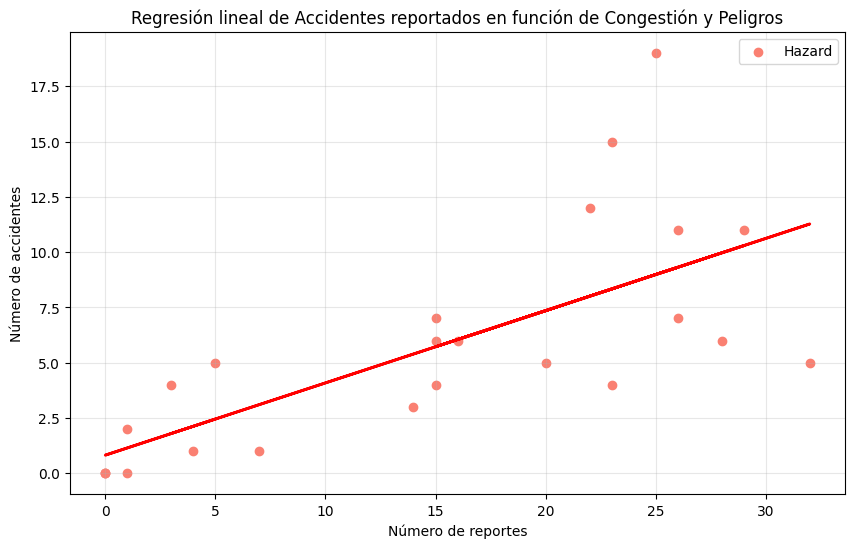

In [18]:
# Grafica la linea de regresión lineal de results y los datos originales

plt.figure(figsize=(10, 6))

# Graficar los datos originales
plt.scatter(dat['Semana'], dat['Semana_accident'], color='salmon', label='Hazard')

# Graficar la línea de regresión
plt.plot(dat['Semana'], results.params['Intercept'] + results.params['Semana'] * dat['Semana'], color='red', linewidth=2)

plt.title('Regresión lineal de Accidentes reportados en función de Congestión y Peligros')
plt.xlabel('Número de reportes')
plt.ylabel('Número de accidentes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()